In [9]:
import numpy as np
import pandas as pd

In [8]:
import distribution_modules as dm
import density_estimation_modules as dem
import classification_modules as cm
import importlib

importlib.reload(dm)
importlib.reload(dem)
importlib.reload(cm)

<module 'classification_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\classification_modules.py'>

In [10]:
# set configurations
num_steps = 10
x = np.linspace(0,1,num_steps)

# cv config
test_size = 0.2
cv = 5
cv_config = [test_size, cv]

In [11]:
data = pd.read_csv('graphwave_ac_data.csv')
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B5_0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B5_0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B5_0


In [12]:
kde_df = dem.get_kde(data, x)

In [13]:
kde_df.head()

,0,1,2,3,4,5,6,7,8,9,label
0,177.533922,6.642079e-24,5.488203e-19,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,B5_0
1,179.581589,7.264006e-48,2.806194e-14,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,B5_0
2,179.581589,7.264006e-48,2.806194e-14,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,B5_0
3,179.581589,7.264006e-48,2.806194e-14,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,B5_0
4,165.684665,3.189130e-02,5.947435e-63,5.789855e-195,0.0,0.0,0.0,0.0,0.0,0.0,B5_1


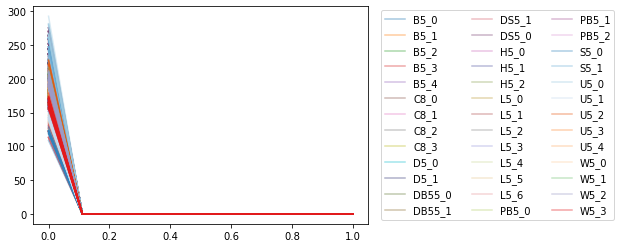

In [14]:
dem.get_kde_plot(kde_df,x)

In [15]:
num_steps_list = list(np.arange(5,200,5))

In [ ]:
res_svm = cm.cv_numsteps(num_steps_list, data, cv_config, 1)

In [18]:
res_lr = cm.cv_numsteps(num_steps_list, data, cv_config, 2)

  0%|          | 0/39 [00:00<?, ?it/s]

KeyboardInterrupt: 

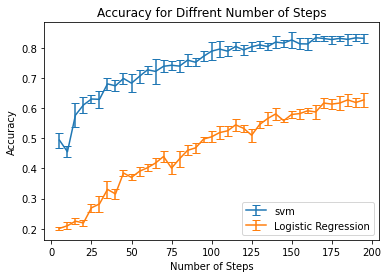

In [131]:
cm.plot_cv_kde(res_svm, res_lr, errbar=1)

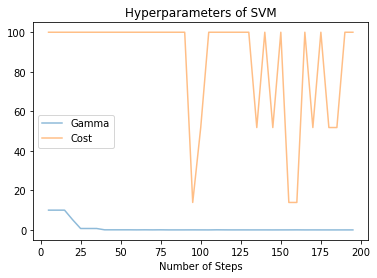

In [133]:
cm.plot_h_params_kde(res_svm)

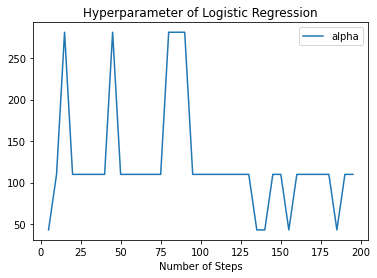

In [147]:
cm.plot_h_params_kde(res_lr)

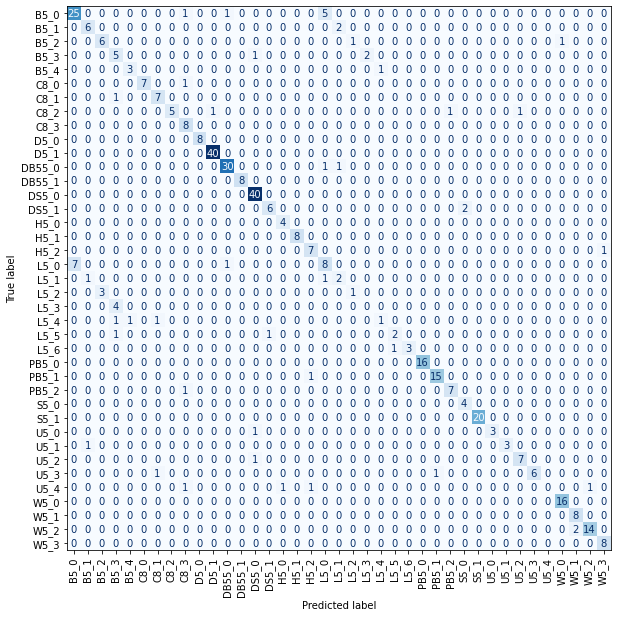

(array([0.81924198, 0.83381924, 0.84502924, 0.84210526, 0.82163743]),
 51.794746792312075,
 0.0071968567300115215)

In [120]:
num_steps = 200
x = np.linspace(0,1,num_steps)
kde_df = dem.get_kde(data, x)
cm.svm_model(kde_df, cv_config, plot=1 )

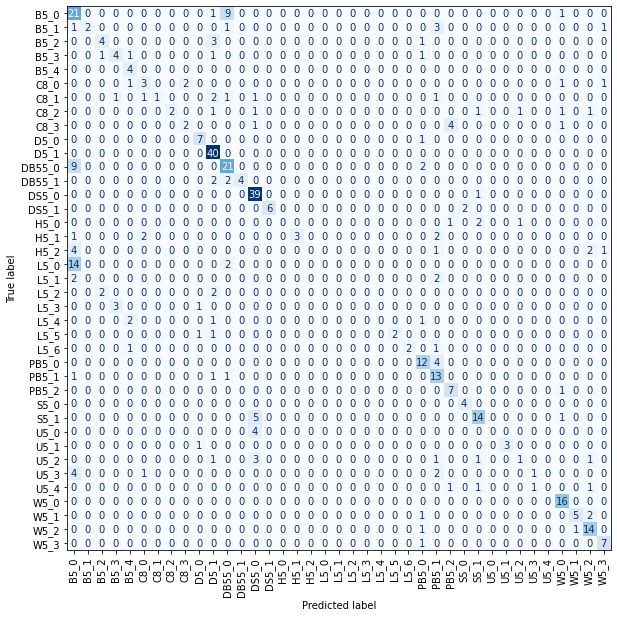

(array([0.62099125, 0.6122449 , 0.65497076, 0.62573099, 0.58187135]),
 109.85411419875584)

In [125]:
num_steps = 200
x = np.linspace(0,1,num_steps)
kde_df = dem.get_kde(data, x)
cm.rr_model(kde_df, cv_config, plot=1 )

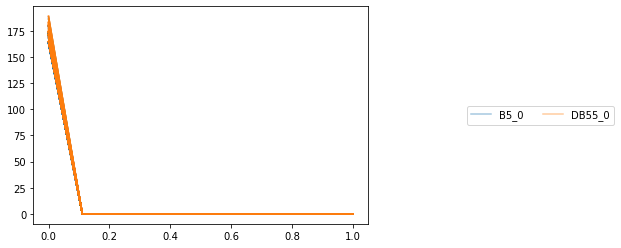

In [149]:
subset = kde_df.loc[(kde_df['label']== 'B5_0') | (kde_df['label']== 'DB55_0')]
dem.get_kde_plot(subset,x)